Here we are basically dealing with shapefiles (.shp). It helps us a lot to load geometry data since data is stored with spatial index and divided in multiple files. We dont need to know what it exactly is, but you can check it out later: https://en.wikipedia.org/wiki/Shapefile

For now we can use data constrained to Manhattan. So, just unzip this at 

    tar -xzf path/to/project/data.tar.gz
    
In case you wanna work with the full datasets:

* https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/pi5s-9p35/data
* https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nynta_17a.zip
* https://data.cityofnewyork.us/City-Government/NYC-Street-Centerline-CSCL-/exjm-f27b/data


### Some tricks to make it easier to reload the modules while coding

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Loading base modules 

In [4]:
import geopandas as gpd
import pandas as pd
import fiona
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10,10]

### Loading datasets

In [5]:
from functools import partial
import pyproj
from shapely.ops import transform

villages = gpd.GeoDataFrame.from_file('data/villages-mn.shp', driver='ESRI Shapefile')
streets = gpd.read_file('data/streets-mn.shp', driver='ESRI Shapefile')
trees = gpd.read_file('data/trees-mn.shp', driver='ESRI Shapefile')

### Converting CRS to UTM ( "flat" the maps, thus spatial queries get much easier)

In [6]:
villages = villages.to_crs(epsg=26918)
streets = streets.to_crs(epsg=26918)
trees = trees.to_crs(epsg=26918)

### Let's plot some trees and streets in MN borough 

as an example, let's quick sample each dataset (saving some time) 

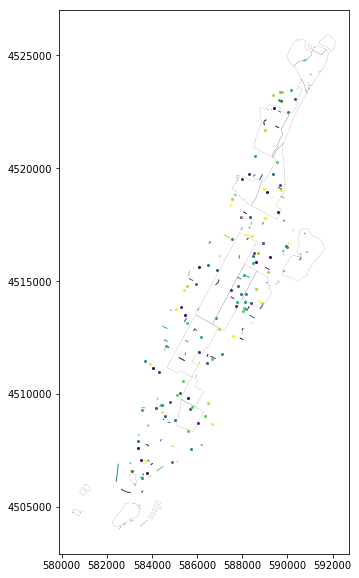

In [7]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
villages.sample(10).plot(ax=ax, color="white", linewidth=.1)
trees.sample(100).plot(ax=ax)
streets.sample(100).plot(ax=ax)

### What are the columns of these dataset?

In [8]:
trees.head()

,address,block_id,boro_ct,borocode,boroname,brnch_ligh,brnch_othe,brnch_shoe,cb_num,cncldist,...,tree_dbh,tree_id,trnk_light,trnk_other,trnk_wire,user_type,x_sp,y_sp,zip_city,zipcode
0,8 COLUMBUS AVENUE,106099.0,1014500,1,Manhattan,No,No,No,107,3.0,...,11.0,190422.0,No,No,No,Volunteer,988418.699656,219825.522669,New York,10023
1,120 WEST 60 STREET,106099.0,1014500,1,Manhattan,No,No,No,107,3.0,...,11.0,190426.0,No,No,No,Volunteer,988311.190028,219885.278455,New York,10023
2,311 WEST 50 STREET,103940.0,1012700,1,Manhattan,No,No,No,104,3.0,...,9.0,208649.0,No,No,No,Volunteer,987769.116309,217157.856088,New York,10019
3,170 EAST 75 STREET,107600.0,1012800,1,Manhattan,No,Yes,No,108,4.0,...,14.0,193310.0,No,Yes,No,Volunteer,995203.003673,220602.155302,New York,10021
4,2163 BROADWAY,107038.0,1016300,1,Manhattan,No,No,No,107,6.0,...,4.0,199760.0,No,No,No,TreesCount Staff,989521.741413,224212.887582,New York,10024


In [9]:
villages.head()

,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Area,Shape_Leng,geometry
0,1,Manhattan,061,MN06,Manhattanville,1.064708e+07,17040.685475,"POLYGON ((588876.1785597933 4519450.267877868,..."
1,1,Manhattan,061,MN17,Midtown-Midtown South,3.019206e+07,27035.738062,"POLYGON ((586678.6911153347 4513097.574779067,..."
2,1,Manhattan,061,MN19,Turtle Bay-East Midtown,1.739787e+07,21638.781375,(POLYGON ((587703.2741437969 4510461.153370242...
3,1,Manhattan,061,MN20,Murray Hill-Kips Bay,1.446596e+07,23135.103743,(POLYGON ((587623.6256422841 4509648.642779417...
4,1,Manhattan,061,MN21,Gramercy,7.531311e+06,12092.422832,"POLYGON ((586251.3783624729 4510040.811386589,..."


### Now, let's find out where trees are located and persist inside their metadata 

In [18]:
if 'village' not in trees.columns:
    def find(x):
        v = villages[villages.intersects(x)]['NTAName'].iloc[0]
        return v 
    trees['village'] = trees['geometry'].apply(lambda x: find(x))
    # let's save this to not run again in future
    trees.to_file('data/trees-mn.shp')

### Group trees by village and checking some basic statistics

In [40]:
groups = trees.groupby('village')
groups.get_group('East Village').describe()

,block_id,cncldist,latitude,longitude,st_assem,st_senate,stump_diam,tree_dbh,tree_id,x_sp,y_sp
count,1581.000000,1581.0,1581.000000,1581.000000,1581.000000,1581.000000,1581.000000,1581.000000,1581.000000,1581.000000,1581.000000
mean,103143.079696,2.0,40.727617,-73.985788,68.754586,26.834915,0.194813,8.621126,187955.486401,988188.949923,204367.448241
std,94.983250,0.0,0.002699,0.003312,3.929826,0.371375,1.696235,5.142160,107997.077119,917.997870,983.268641
min,102936.000000,2.0,40.721669,-73.992359,65.000000,26.000000,0.000000,0.000000,33924.000000,986367.889453,202200.276752
25%,103070.000000,2.0,40.725432,-73.988459,66.000000,27.000000,0.000000,4.000000,103399.000000,987448.820034,203570.975782
50%,103151.000000,2.0,40.727832,-73.985875,66.000000,27.000000,0.000000,8.000000,141214.000000,988165.004297,204445.564256
75%,103217.000000,2.0,40.729734,-73.983243,74.000000,27.000000,0.000000,12.000000,233090.000000,988894.555332,205138.398500
max,103412.000000,2.0,40.734020,-73.978275,74.000000,27.000000,33.000000,30.000000,560268.000000,990271.151660,206699.924905


### We can compile some interesting stuff as following (check the pdf which explains the metadata!)

In [44]:
for i,v in villages.iterrows():
    
    # first we get the group
    village_trees = groups.get_group(v['NTAName'])
    
    # now we count the ammount of trees
    count = len(village_trees)
    
    # since we have the geometry, we can find i.e. the density of trees
    density = len(village_trees)/v['geometry'].area
    
    # we can check the median of the height!
    height_mean = village_trees.tree_dbh.mean()
    
    villages.set_value(i,'count', count)
    villages.set_value(i,'density',density)
    villages.set_value(i,'height_mean', height_mean)

## .. and finally plot..

using "YlGn" as a colormap, we have lower (YELLOW) and higher (GREEN). Later we can add colormap bars!

### .. the density of trees per villages.. 
* Question! What do you think about Central Park's color?  (Hint: it is a hugh space and has a lot of meadows)

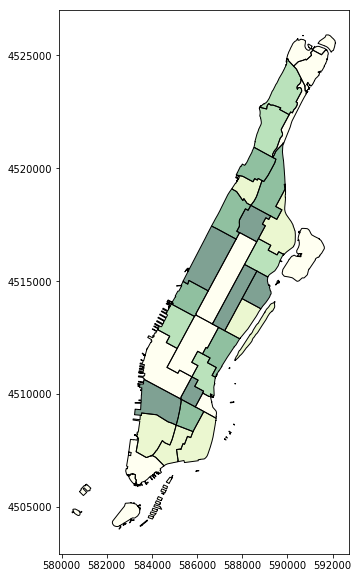

In [43]:
kw = dict(column='density', k=10, colormap='YlGn')
villages.plot(scheme='QUANTILES', **kw)

### .. now, look at the average height of the trees .. 
* check Central Park again!

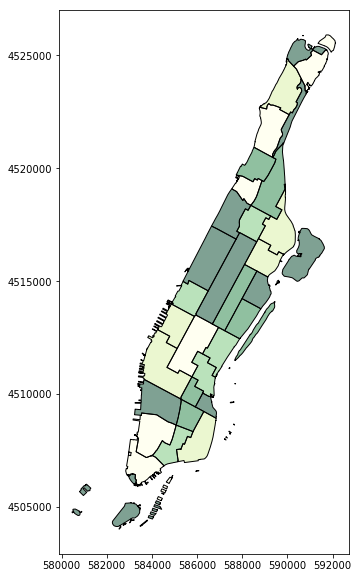

In [45]:
kw = dict(column='height_mean', k=10, colormap='YlGn')
villages.plot(scheme='QUANTILES', **kw)